In [41]:
import torch
import torch.nn as nn 
from torch.functional import F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
import datashader as ds
import datashader.transfer_functions as tf
import seaborn as sns

from functools import partial
from tqdm.notebook import tqdm
from sconf import Config

import sys
sys.path.append('..')

from classes import MLP, MultiTaskLoss
from utils import non_markovian_midprice

In [42]:
config = Config('config.yaml')

In [43]:
rng = np.random.default_rng(123)

num_paths = config.num_paths
num_timesteps = config.num_timesteps
final_time = config.final_time
initial_price = config.initial_price
decomp_dim = config.decomp_dim
num_episodes = config.num_episodes
batch_size = config.batch_size

dt = final_time/num_timesteps

inital_prices = np.ones((1, num_paths)) * initial_price

permenant_price_impact_func = lambda x: 0.01*x
# kernel_function = lambda x,y: (np.abs((x-y)+1e-3)**(0.51-1))
# kernel_function = lambda x,y: (1/(np.sqrt(2*np.pi)))*np.exp(-(x-y)**2)
kernel_function = lambda x,y: np.exp(-np.abs((x-y)))
K0 = kernel_function(0,0)

nu_vals = rng.uniform(-50, 100,size=(num_timesteps, num_paths))

sigma_true = 0.1

# Generate Data

In [44]:
sim_prices, noise_process = non_markovian_midprice(inital_prices=inital_prices,
                             permenant_price_impact_func=permenant_price_impact_func,
                             nu_vals=nu_vals,
                             kernel_function=kernel_function,
                             dt=dt,
                             rng=rng,
                             num_paths=num_paths,
                             num_timesteps=num_timesteps,
                             sigma=sigma_true)

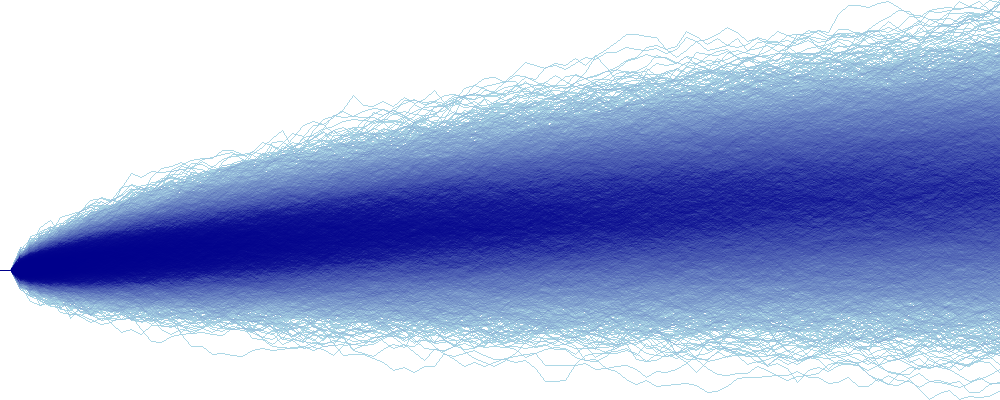

In [45]:
n = num_paths
points = num_timesteps
time = np.linspace(0, 1, num_timesteps)

walks = pd.DataFrame(sim_prices.T)

cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(walks, x=time, y=list(range(points)), agg=ds.count(), axis=1, line_width=0)
img = tf.shade(agg, how='eq_hist')

img

# NN Approach

In [46]:
network = MLP(decomp_dim=decomp_dim)
mtloss = MultiTaskLoss(num_losses=2)
optimizer = torch.optim.Adam(params=[*network.parameters(), 
                                     *mtloss.parameters()
                                     ],
                             lr=3e-4)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

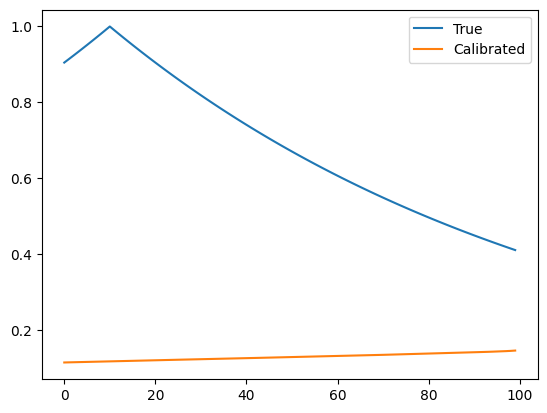

  0%|          | 0/39 [00:00<?, ?it/s]

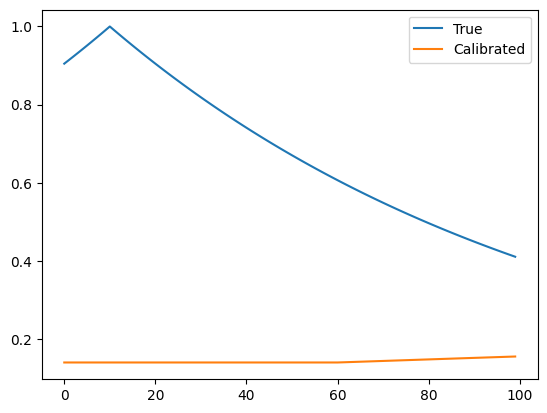

  0%|          | 0/39 [00:00<?, ?it/s]

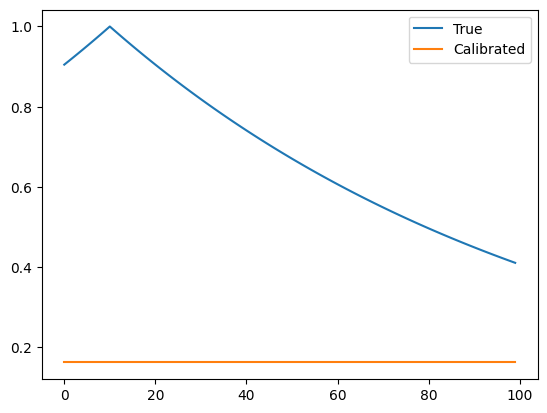

  0%|          | 0/39 [00:00<?, ?it/s]

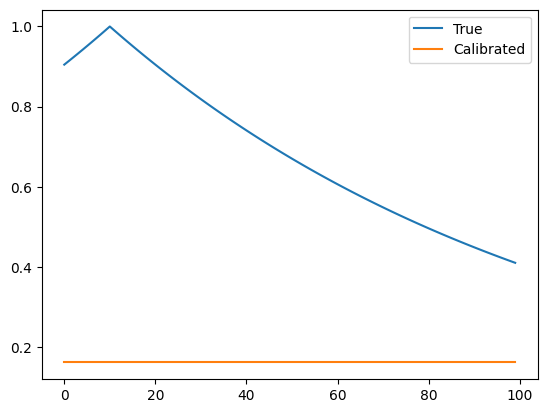

  0%|          | 0/39 [00:00<?, ?it/s]

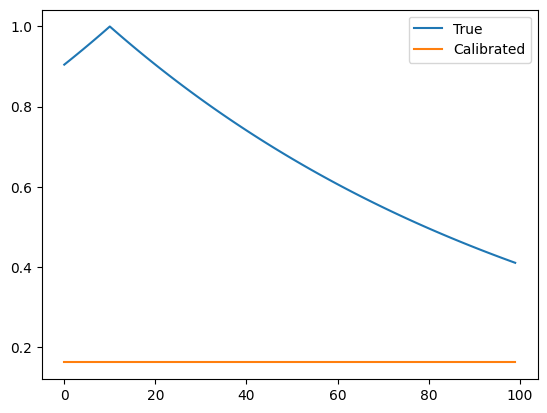

  0%|          | 0/39 [00:00<?, ?it/s]

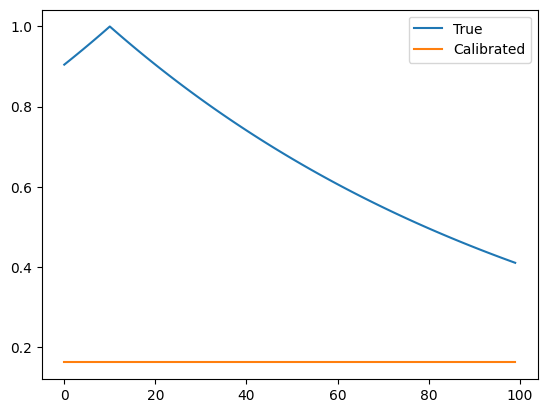

  0%|          | 0/39 [00:00<?, ?it/s]

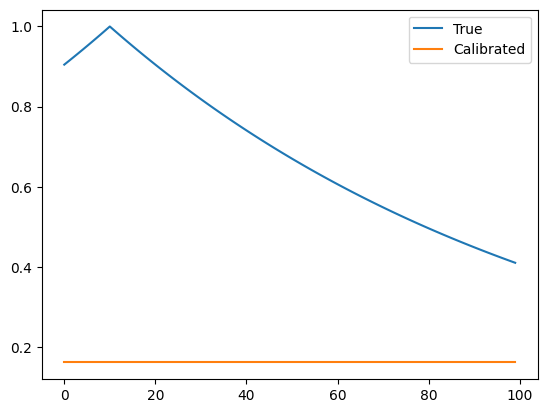

  0%|          | 0/39 [00:00<?, ?it/s]

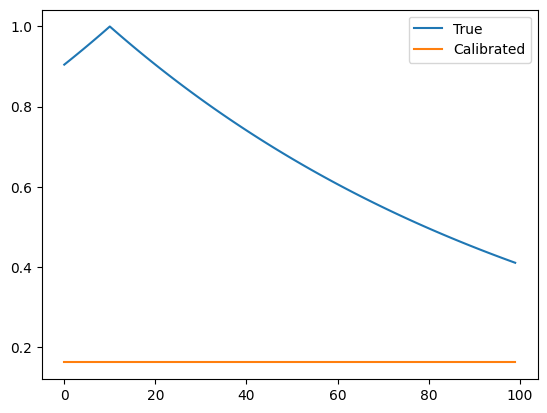

  0%|          | 0/39 [00:00<?, ?it/s]

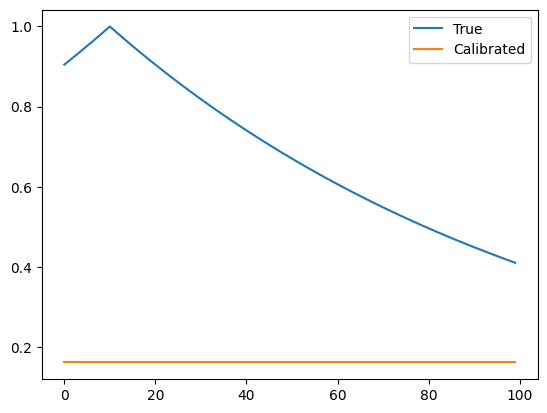

  0%|          | 0/39 [00:00<?, ?it/s]

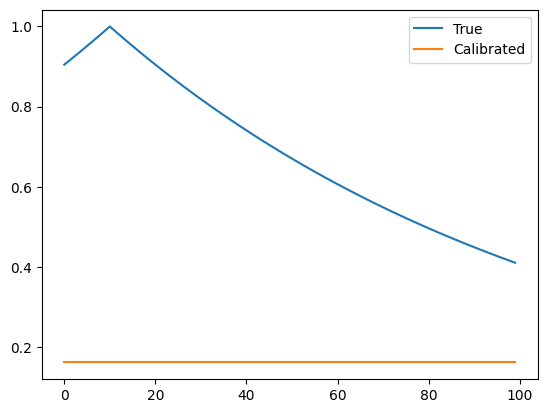

  0%|          | 0/39 [00:00<?, ?it/s]

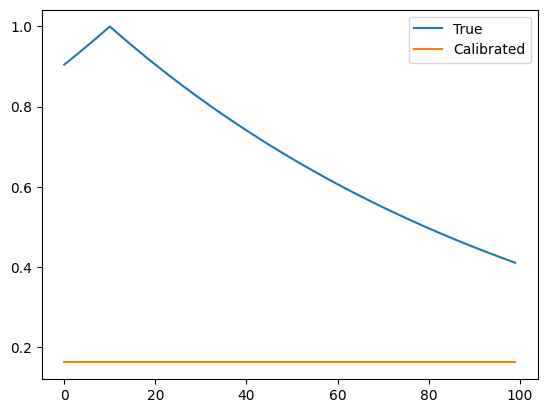

  0%|          | 0/39 [00:00<?, ?it/s]

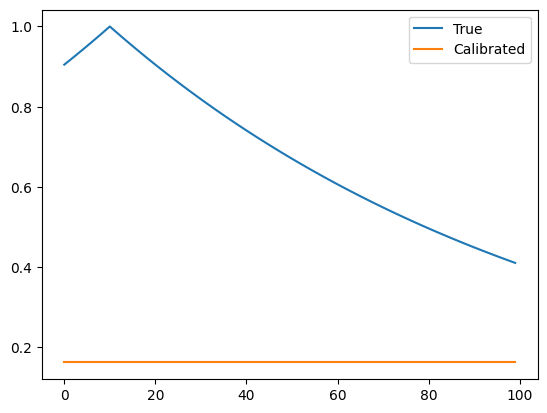

  0%|          | 0/39 [00:00<?, ?it/s]

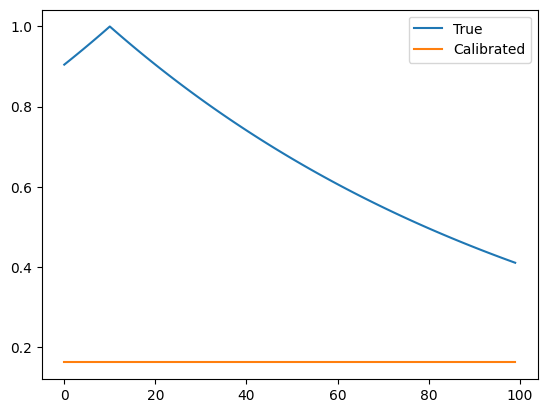

  0%|          | 0/39 [00:00<?, ?it/s]

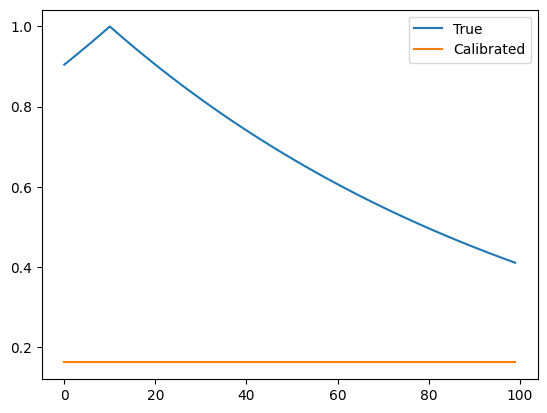

  0%|          | 0/39 [00:00<?, ?it/s]

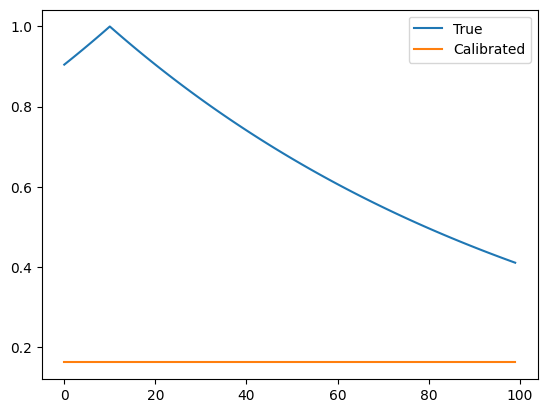

  0%|          | 0/39 [00:00<?, ?it/s]

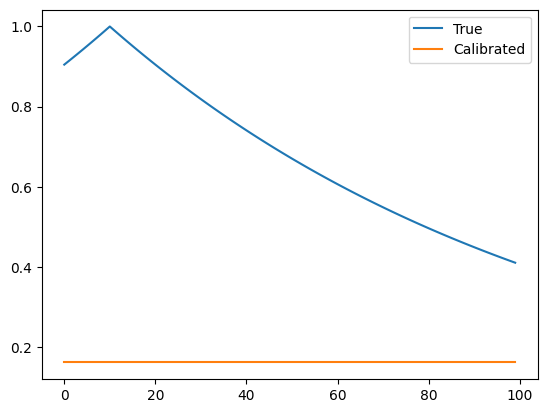

  0%|          | 0/39 [00:00<?, ?it/s]

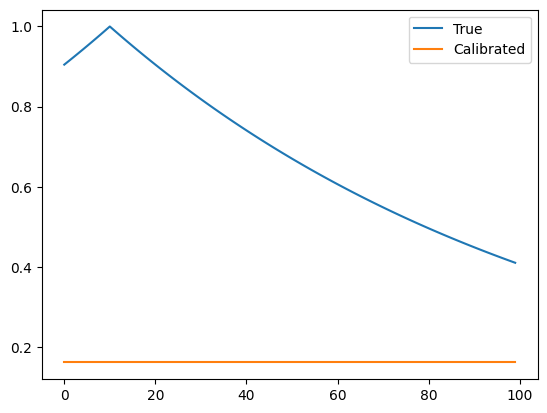

  0%|          | 0/39 [00:00<?, ?it/s]

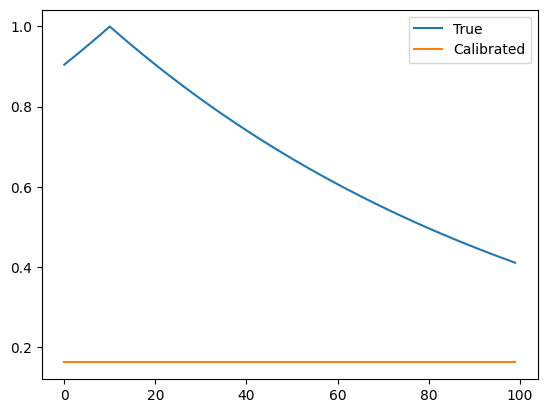

  0%|          | 0/39 [00:00<?, ?it/s]

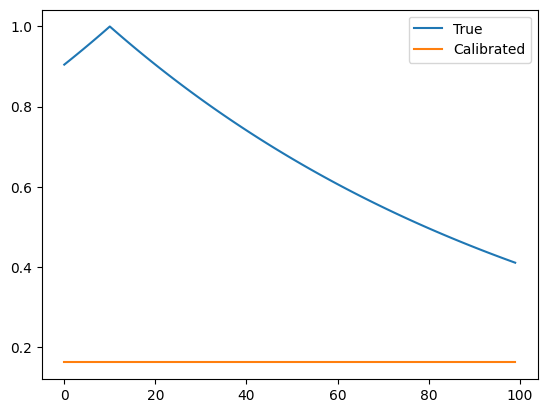

  0%|          | 0/39 [00:00<?, ?it/s]

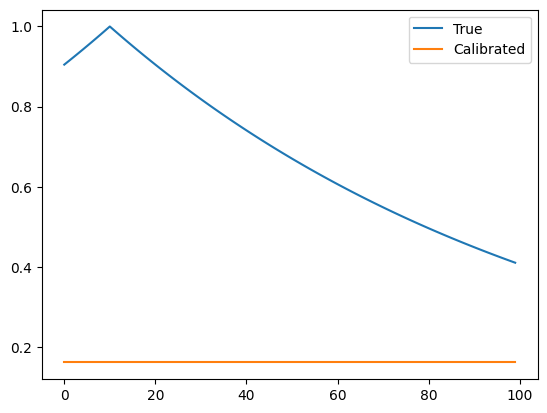

  0%|          | 0/39 [00:00<?, ?it/s]

In [47]:
loss_vals = {}
sigma_tracker = {}
kappa_tracker = {}
for episode in tqdm(range(num_episodes), position=0, leave=True):
    loss_vals[episode] = []
    sigma_tracker[episode] = []
    kappa_tracker[episode] = []
    for batch_index in tqdm(range(1, int(num_paths/batch_size)+1), position=1, leave=True):

        lower_bound = int((batch_index-1)*batch_size)
        upper_bound = int((batch_index)*batch_size)

        B_n_t = torch.zeros((batch_size, decomp_dim))

        true_vals = sim_prices[:, lower_bound:upper_bound]
        batch_nu_vals = nu_vals[:, lower_bound:upper_bound]

        for timestep in range(1, num_timesteps):

            true_vals_t = torch.FloatTensor(true_vals[timestep, :])
            true_vals_t_plus_one = torch.FloatTensor(true_vals[timestep+1, :])

            batch_nu_vals_t = torch.FloatTensor(batch_nu_vals[timestep])
            price_impacts = network.permenant_price_impact_func(batch_nu_vals_t).reshape(batch_size)

            time_tensor = torch.FloatTensor([timestep*dt])
            f_vals = network(time_tensor)
            K_t_t = network.approx_func(time_tensor.reshape(1,-1),time_tensor.reshape(1,-1)).flatten()

            # Calculate first f(X_t, t; \theta) term
            f_x_t_one = price_impacts.reshape(batch_size) * K_t_t

            # Calculate Second f(X_t, t; \theta) term
            # Calcutate f_n'(t)
            grad_time_tensor = torch.FloatTensor([timestep*dt])
            grad_time_tensor.requires_grad = True
            f_prime_vals = torch.autograd.functional.jacobian(network, 
                                                              grad_time_tensor, 
                                                              create_graph=True)
            f_prime_vals = f_prime_vals.flatten()
            dB_n_t = f_vals.reshape(1, decomp_dim) * price_impacts.reshape(batch_size,1) * dt
            
            B_n_t = B_n_t.detach() + dB_n_t

            f_x_t_two =  (B_n_t.reshape(batch_size, decomp_dim) * f_prime_vals.reshape(1, decomp_dim)).sum(dim=1)

            f_x_t = f_x_t_one + f_x_t_two

            L_x_t = network.sigma
            loss_term_one = 0.5 * torch.log(2 * torch.pi * torch.abs(0.5*(L_x_t**2)*dt))
            loss_term_two_temp = ((true_vals_t_plus_one - true_vals_t) - f_x_t*dt)
            loss_term_two = 0.5*(loss_term_two_temp**2) / ((L_x_t**2)*dt)

            likely_hood_loss = (loss_term_one+loss_term_two).mean()

            likely_hood_loss_temp = likely_hood_loss.detach().item()

            ##################################################################################
            ##################################################################################
            # Enforcing K(t,t) = K(s,s) 
            time_one = torch.FloatTensor(rng.uniform(0, num_timesteps, batch_size)).reshape(-1,1)*dt
            time_two = torch.FloatTensor(rng.uniform(0, num_timesteps, batch_size)).reshape(-1,1)*dt
            K_one_two = network.approx_func(time_one, time_two)

            # true_val = torch.FloatTensor(kernel_function(time_one.detach().numpy(), 
            #                                      time_two.detach().numpy())).flatten()

            # true_error = torch.pow(true_val-K_one_two, 2)

            K_one_one = network.approx_func(time_one, time_one).flatten()
            K_two_two = network.approx_func(time_two, time_two).flatten()

            kernel_error_one = torch.pow(K_one_one-torch.FloatTensor([K0]), 2)
            kernel_error_two = torch.pow(K_two_two-torch.FloatTensor([K0]), 2)
            kernel_error_three = torch.pow(K_one_one-K_two_two, 2)

            # Translation Invariance 
            delta = torch.FloatTensor(rng.uniform(-num_timesteps,
                                                  num_timesteps, 
                                                  batch_size)).reshape(-1,1)*dt

            time_one_delta = time_one + delta
            time_two_delta = time_two + delta
            K_one_two_delta = network.approx_func(time_one_delta, time_two_delta).flatten()
            kernel_error_four = torch.pow(K_one_two-K_one_two_delta, 2)

            kernel_error_five = torch.pow(torch.max(torch.zeros_like(K_one_one), -K_one_one), 2)
            kernel_error_six = torch.pow(torch.max(torch.zeros_like(K_two_two), -K_two_two), 2)
            kernel_error_seven = torch.pow(torch.max(torch.zeros_like(K_one_two), -K_one_two), 2)

            kernel_error = (
                            # true_error.detach().mean().item(),
                            kernel_error_one.detach().mean().item(), 
                            kernel_error_two.detach().mean().item(), 
                            kernel_error_three.detach().mean().item(),
                            # kernel_error_four.detach().mean().item(),
                            kernel_error_five.detach().mean().item(),
                            kernel_error_six.detach().mean().item(),
                            kernel_error_seven.detach().mean().item(),
                            # asymtopic_loss.detach().mean().item()
                            )
            
            ##################################################################################
            ##################################################################################
            
            loss_tensor = torch.hstack([
                                        likely_hood_loss,
                                        # true_error.mean(),
                                        # kernel_error_one.mean(), # + kernel_error_two.mean() +kernel_error_three.mean(), 
                                        # kernel_error_four.mean(),
                                        # kernel_error_five.mean()+kernel_error_six.mean()+ kernel_error_seven.mean(),
                                        # asymtopic_loss.mean()
                                        ])

            if len(loss_tensor) == 1:
                loss = loss_tensor.mean()
            else:
                loss = mtloss(loss_tensor)
            
            kappa_tracker[episode].append(network.kappa.detach().item())
            sigma_tracker[episode].append(network.sigma.detach().item())
            loss_vals[episode].append({'mt_loss': loss.detach().item(),
                                       **{f"kernel_loss_{i}": _ for i, _ in enumerate(kernel_error)},
                                       'likelyhood_loss': likely_hood_loss_temp})

            network.zero_grad()
            optimizer.zero_grad()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(network.parameters(), 1)
            optimizer.step()

            network.zero_grad()
            optimizer.zero_grad()
                
    s_val = 10
    kernel_plot = []
    kernel_plot_two = []

    for i in range(0, num_timesteps):
        k_s_t = network.approx_func(torch.FloatTensor([s_val*dt]).reshape(-1,1), torch.FloatTensor([i*dt]).reshape(1,-1))
        kernel_plot.append(k_s_t.detach().item())

    partial_func = partial(kernel_function, y=s_val*dt)
    for i in range(0, num_timesteps):
        val = partial_func(i*dt)
        kernel_plot_two.append(val)

    plt.plot(kernel_plot_two, label='True')
    plt.plot(kernel_plot, label='Calibrated')
    plt.legend()
    plt.show()

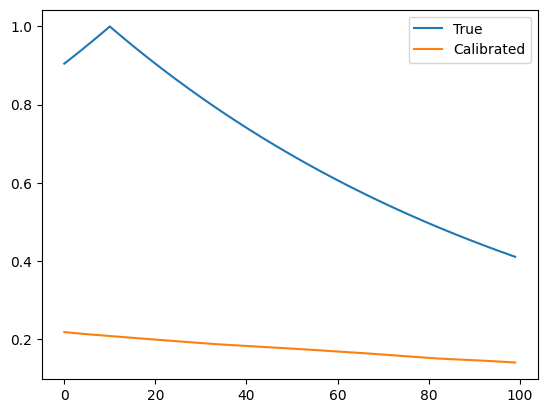

In [ ]:
s_val = 10
kernel_plot = []
kernel_plot_two = []

for i in range(0, num_timesteps):
    k_s_t = network.approx_func(torch.FloatTensor([s_val*dt]).reshape(-1,1), torch.FloatTensor([i*dt]).reshape(1,-1))
    kernel_plot.append(k_s_t.detach().item())

partial_func = partial(kernel_function, y=s_val*dt)
for i in range(0, num_timesteps):
    val = partial_func(i*dt)
    kernel_plot_two.append(val)

plt.plot(kernel_plot_two, label='True')
plt.plot(kernel_plot, label='Calibrated')
plt.legend()
plt.show()

# Validation Prices

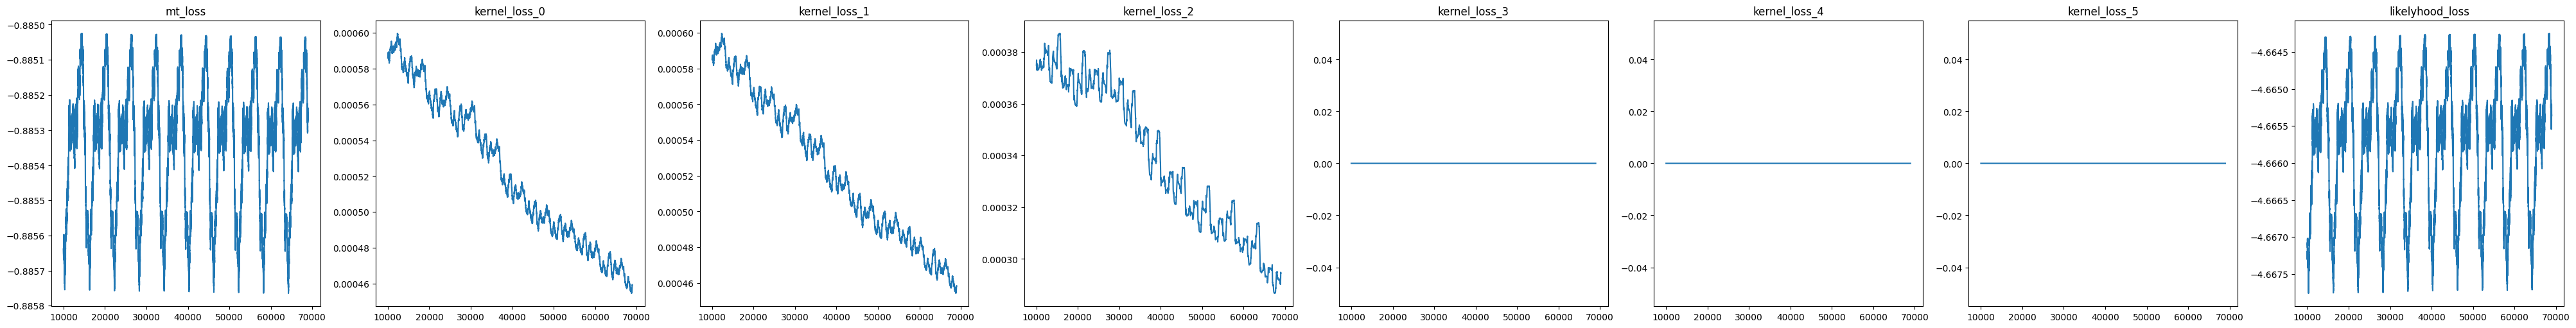

In [ ]:
loss_types = tuple(loss_vals[0][0].keys())

fig, ax = plt.subplots(1, len(loss_types), figsize=(5*len(loss_types), 5), constrained_layout=True)

for plot_index, loss_type in enumerate(loss_types):
    ax[plot_index].plot(pd.concat([pd.DataFrame(loss_vals[_])[loss_type][:] for _ in loss_vals.keys()]).rolling(10*num_timesteps).mean().values)
    ax[plot_index].set_title(loss_type)

plt.show()

# Distribution Plots

In [ ]:
val_nu_vals = rng.uniform(-50, 100,size=(num_timesteps, 10_000))
val_inital_prices = np.ones((1, 10_000)) * initial_price
val_sim_prices, _ = non_markovian_midprice(inital_prices=val_inital_prices,
                             permenant_price_impact_func=permenant_price_impact_func,
                             nu_vals=val_nu_vals,
                             kernel_function=kernel_function,
                             dt=dt,
                             rng=rng,
                             num_paths=10_000,
                             num_timesteps=num_timesteps,
                             sigma=sigma_true)

In [ ]:
network.eval()

batch_size = 10_000

batch_nu_vals = rng.uniform(-50, 100,size=(num_timesteps, batch_size))

B_n_t = torch.zeros((decomp_dim, batch_size))
S_t = torch.ones((1, batch_size)) * initial_price

B_n_list = [B_n_t.detach().numpy()]
S_t_list = [S_t.detach().numpy()]

for timestep in range(1, num_timesteps):

    price_impacts =  network.kappa *  torch.FloatTensor(batch_nu_vals[timestep])
    net_vals = network(torch.FloatTensor([timestep*dt]))

    f_vals = net_vals
    
    time_tensor = torch.FloatTensor([timestep*dt])
    time_tensor.requires_grad = True

    f_prime_vals = torch.autograd.functional.jacobian(network, 
                                    time_tensor, 
                                    create_graph=True)
    
    f_prime_vals = f_prime_vals.flatten()

    kernel_time_t = f_vals.dot(f_vals)
    kernel_price_impact = kernel_time_t * price_impacts * dt

    w_t = (dt**0.5)*torch.randn((batch_size))
    sigma_w_t = network.sigma * w_t

    dB_n_t = torch.tile(f_vals, dims=(batch_size, 1)).T * price_impacts * dt
    B_n_t = B_n_t.detach() + dB_n_t
    B_n_list.append(B_n_t.detach().numpy())

    sum_of_sub_procces = torch.matmul(f_prime_vals, B_n_t) * dt

    dS_t = kernel_price_impact + sigma_w_t + sum_of_sub_procces 
    S_t = S_t.detach() + dS_t

    S_t_list.append(S_t.detach().numpy())

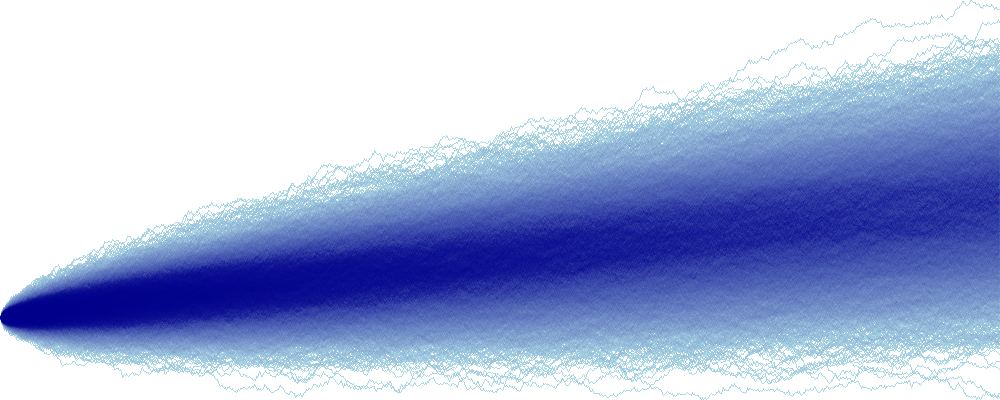

In [ ]:
nn_sim_prices = np.vstack(S_t_list)

n = num_paths
points = num_timesteps
time = np.linspace(0, 1, num_timesteps)

walks = pd.DataFrame(nn_sim_prices.T)

cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(walks, x=time, y=list(range(points)), agg=ds.count(), axis=1, line_width=0)
img = tf.shade(agg, how='eq_hist')

img

# Distribution Plots

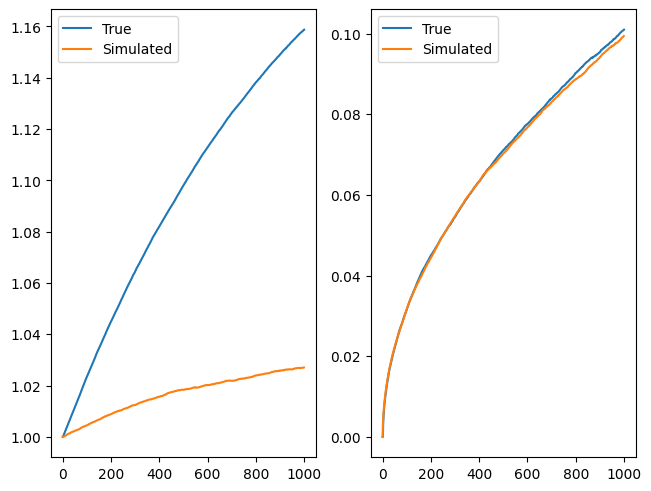

In [ ]:
fig, ax = plt.subplots(1,2, constrained_layout=True)

nn_sim_prices = np.vstack(S_t_list)

ax[0].plot(val_sim_prices[:, :10_000].mean(axis=1), label='True')
ax[0].plot(nn_sim_prices.mean(axis=1), label='Simulated')
ax[0].legend()

ax[1].plot(val_sim_prices[:, :10_000].std(axis=1), label='True')
ax[1].plot(nn_sim_prices.std(axis=1), label='Simulated')
ax[1].legend()

plt.show()

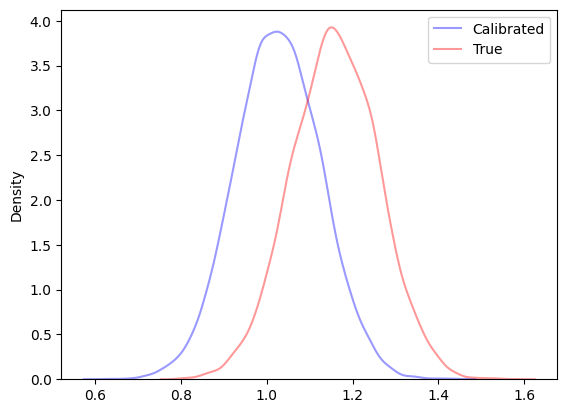

In [ ]:
final_sim_prices = np.vstack(S_t_list)[-1]
final_val_sim_prices = val_sim_prices[-1]

sns.kdeplot(final_sim_prices, alpha=0.4, color='blue', label='Calibrated')
sns.kdeplot(final_val_sim_prices, alpha=0.4, color='red', label='True')
plt.legend()
plt.show()

# Kernel Plots

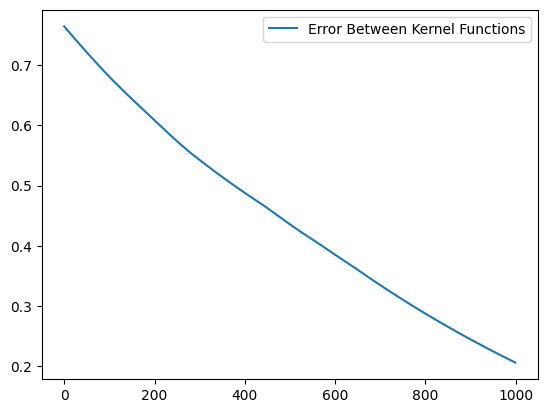

In [ ]:
kernel_plot = []
kernel_plot_two = []

base_val = network(torch.FloatTensor([0])).detach()
for i in range(0, num_timesteps):
    val = network(torch.FloatTensor([i*dt]))
    kernel_plot.append(val.dot(base_val).detach().item())

partial_func = partial(kernel_function, y=0)
for i in range(0, num_timesteps):
    val = partial_func(i*dt)
    kernel_plot_two.append(val)

plt.plot(np.abs(np.array(kernel_plot_two)-np.array(kernel_plot)),
         label='Error Between Kernel Functions')
plt.legend()
plt.show()